In [122]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from pathlib import Path
import glob
import re

from plaid.evaluation import batch_rmsd_calculation, batch_rmspd_from_pdb_paths, run_tmalign
from plaid.utils import read_sequences_from_fasta, calc_sequence_recovery

import re
import wandb

# Naturalness

In [127]:
import glob
gen_samples = glob.glob("/data/lux70/plaid/artifacts/samples/by_length/5j007z42/f2219_o3617/ddim/**/phantom_generated/structures/*pdb", recursive=True)
gen_samples.sort()
print(len(gen_samples))
print(gen_samples[:4])

from plaid.utils import extract_avg_b_factor_per_residue

all_plddts = {}

for pdb_path in gen_samples:
    plddts = extract_avg_b_factor_per_residue(pdb_path)
    all_plddts[pdb_path] = np.mean(plddts)

384
['/data/lux70/plaid/artifacts/samples/by_length/5j007z42/f2219_o3617/ddim/ive5gowq/phantom_generated/structures/sample0.pdb', '/data/lux70/plaid/artifacts/samples/by_length/5j007z42/f2219_o3617/ddim/ive5gowq/phantom_generated/structures/sample1.pdb', '/data/lux70/plaid/artifacts/samples/by_length/5j007z42/f2219_o3617/ddim/ive5gowq/phantom_generated/structures/sample10.pdb', '/data/lux70/plaid/artifacts/samples/by_length/5j007z42/f2219_o3617/ddim/ive5gowq/phantom_generated/structures/sample100.pdb']


/tmp/ipykernel_3591431/3921066663.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(list(all_plddts.values()),bins=30)


Text(0.5, 1.0, 'pLDDT for sequences of lengths {100, 200, 300}')

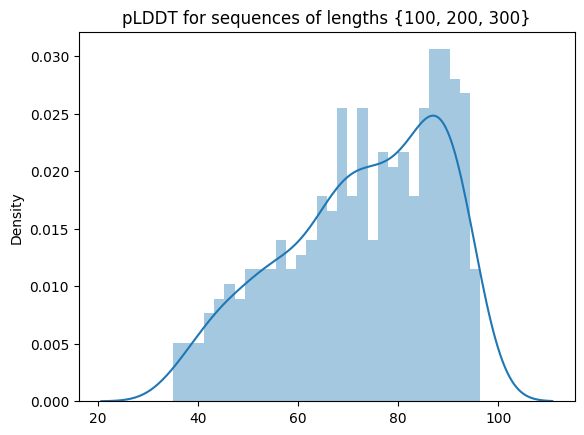

In [129]:
# _ = plt.hist(all_plddts, bins=30)
sns.distplot(list(all_plddts.values()),bins=30)
plt.title("pLDDT for sequences of lengths {100, 200, 300}")

In [174]:
from plaid.utils import read_sequences_from_fasta
seqs = []
fastas = glob.glob("/data/lux70/plaid/artifacts/samples/by_length/5j007z42/f2219_o3617/ddim/**/generated/sequences.fasta")
for fasta in fastas:
    seqd = read_sequences_from_fasta(fasta)
    seqs.extend(list(seqd.values()))
print(len(seqs))

384


In [179]:
from plaid.evaluation import RITAPerplexity
rita_pl = RITAPerplexity()
pls = [rita_pl.calc_perplexity(s) for s in seqs]
print(len(pls))

/homefs/home/lux70/micromamba/envs/omegafold/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


384


In [ ]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size']=8

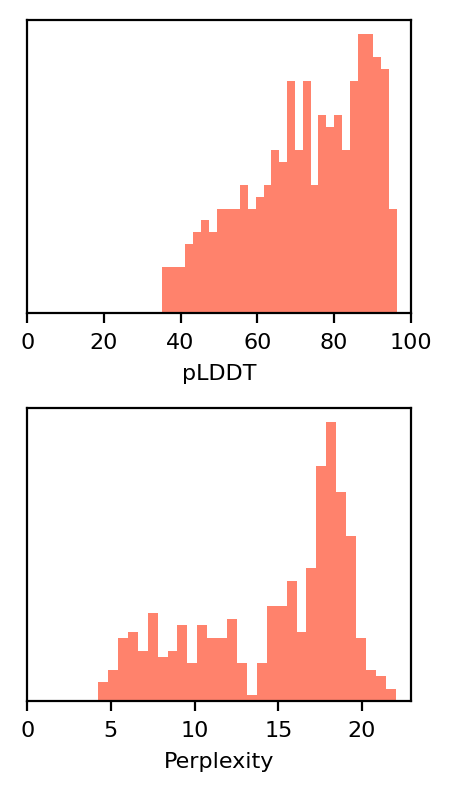

In [234]:
sty_kwargs = {"alpha":0.8, "color":"tomato"}

fig, axs = plt.subplots(2,1, figsize=(2.3,4),dpi=200)
axs[0].hist(list(all_plddts.values()),bins=30,**sty_kwargs)
axs[0].set_ylabel("")
axs[0].set_yticks([])
axs[0].set_xlabel("pLDDT")
axs[0].set_xticks(range(0,101,20))

axs[1].hist(pls,bins=30,**sty_kwargs)
axs[1].set_ylabel("")
axs[1].set_yticks([])
axs[1].set_xlabel("Perplexity")
axs[1].set_xticks(range(0,24,5))


plt.tight_layout()
plt.show()

# Consistency

In [135]:
# grab all generated structures

# ive5gowq  o9cma5q0  xt5ba20h

import glob
gen_samples = glob.glob("/data/lux70/plaid/artifacts/samples/by_length/5j007z42/f2219_o3617/ddim/**/generated/structures/*pdb", recursive=True)
gen_samples.sort()
print(len(gen_samples))
print(gen_samples[:4])

inverse_gen_pdbs = glob.glob("/data/lux70/plaid/artifacts/samples/by_length/5j007z42/f2219_o3617/ddim/**/inverse_generated/structures/*pdb", recursive=True)
inverse_gen_pdbs.sort()
print(len(inverse_gen_pdbs))
print(inverse_gen_pdbs[:4])

384
['/data/lux70/plaid/artifacts/samples/by_length/5j007z42/f2219_o3617/ddim/ive5gowq/generated/structures/sample0.pdb', '/data/lux70/plaid/artifacts/samples/by_length/5j007z42/f2219_o3617/ddim/ive5gowq/generated/structures/sample1.pdb', '/data/lux70/plaid/artifacts/samples/by_length/5j007z42/f2219_o3617/ddim/ive5gowq/generated/structures/sample10.pdb', '/data/lux70/plaid/artifacts/samples/by_length/5j007z42/f2219_o3617/ddim/ive5gowq/generated/structures/sample100.pdb']
384
['/data/lux70/plaid/artifacts/samples/by_length/5j007z42/f2219_o3617/ddim/ive5gowq/inverse_generated/structures/sequence_0.pdb', '/data/lux70/plaid/artifacts/samples/by_length/5j007z42/f2219_o3617/ddim/ive5gowq/inverse_generated/structures/sequence_1.pdb', '/data/lux70/plaid/artifacts/samples/by_length/5j007z42/f2219_o3617/ddim/ive5gowq/inverse_generated/structures/sequence_10.pdb', '/data/lux70/plaid/artifacts/samples/by_length/5j007z42/f2219_o3617/ddim/ive5gowq/inverse_generated/structures/sequence_100.pdb']


In [136]:
ccrmsd = batch_rmsd_calculation(inverse_gen_pdbs, gen_samples)
cctm = [run_tmalign(p1,p2) for (p1,p2) in zip(inverse_gen_pdbs, gen_samples)]

In [148]:
from plaid.evaluation._structure_metrics import calculate_rmsd

ccrmsd_allatom = [calculate_rmsd(p1,p2,ca_only=False) for (p1, p2) in zip(inverse_gen_pdbs, gen_samples)]

In [140]:
import glob
phantom_gen_samples = glob.glob("/data/lux70/plaid/artifacts/samples/by_length/5j007z42/f2219_o3617/ddim/**/phantom_generated/structures/*pdb", recursive=True)
phantom_gen_samples.sort()

scrmsd = batch_rmsd_calculation(inverse_gen_pdbs, phantom_gen_samples)
sctm = [run_tmalign(p1,p2) for (p1,p2) in zip(inverse_gen_pdbs, phantom_gen_samples)]

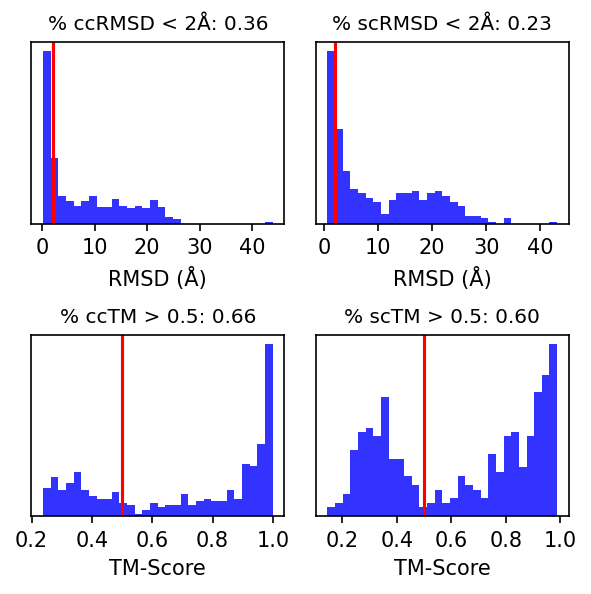

In [228]:
fig, axs = plt.subplots(2,2, figsize=(4,4))


ccrmsd = np.array(ccrmsd)
ccrmsd_thres = ((ccrmsd < 2).sum() / len(ccrmsd))

sty_kwargs={"alpha":0.8,"color":"blue","bins":30}




# RMSDs
axs[0][0].hist(ccrmsd,**sty_kwargs)
axs[0][0].set_title(f"% ccRMSD < 2Å: {ccrmsd_thres:.2f}")

scrmsd = np.array(scrmsd)
scrmsd_thres = (scrmsd < 2).sum() / len(scrmsd)

axs[0][1].hist(scrmsd,**sty_kwargs)
axs[0][1].set_title(f"% scRMSD < 2Å: {scrmsd_thres:.2f}")

for j in range(2):
    axs[0][j].axvline(x=2,color="red")
    axs[0][j].set_xlabel("RMSD (Å)")
    axs[0][j].set_yticks([])


## TMs
cctm_thres = (np.array(cctm) > 0.5).sum() / len(cctm)
sctm_thres = (np.array(sctm) > 0.5).sum() / len(sctm)

axs[1][0].hist(cctm,**sty_kwargs)
axs[1][0].set_title(f"% ccTM > 0.5: {cctm_thres:.2f}")

axs[1][1].hist(sctm,**sty_kwargs)
axs[1][1].set_title(f"% scTM > 0.5: {sctm_thres:.2f}")

for j in range(2):
    axs[1][j].axvline(x=0.5,color="red")
    axs[1][j].set_xlabel("TM-Score")
    axs[1][j].set_yticks([])

plt.tight_layout()
plt.show()